# Classification de locuteur

#### Objectif : créer une chaine de traitement des données textuelles sur la classification de locuteur

#### Jeu de données : citations Chirac Mitterand

* Analyses obligatoires
    * Comparer les performances avec différents pré-traitements
        * e.g Taille de vocabulaire, unigram/bigram, Stemming, ...
    * Implémenter un post-traitement sur les données Chirac/Mitterrand
    * Appliquer les traitements optimaux sur les données de test et sauver les résultats dans un fichier txt

* Compléments optionnels
    * Analyser les performances avec Word2Vec, en utilisant des stratégies d'agrégation naïves

## Import des librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import codecs
import re
import seaborn as sns

In [2]:
path = "data/AFDpresidentutf8/corpus.tache1.learn.utf8"

## Chargement des données Mitterand / Chirac

In [3]:
def load_pres(fname):
    alltxts = []
    alllabs = []
    s=codecs.open(fname, 'r','utf-8') # pour régler le codage
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        #
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)
        if lab.count('M') >0:
            alllabs.append(0)
        else: 
            alllabs.append(1)
        alltxts.append(txt)
    return alltxts,alllabs

In [4]:
alltxts,alllabs = load_pres(path)

In [58]:
np.unique(alllabs, return_counts=True)

(array([0, 1]), array([ 7523, 49890]))

### Verification de l'équilibre du plan d'expérience

In [5]:
C, M = np.unique(alllabs, return_counts=True)[1]
print(f"Il y a {M/(C+M) * 100} % de citations attribuées à Mitterand et {C/(C+M) * 100} % de citations attribuées à Chirac ")

Il y a 86.89669587027329 % de citations attribuées à Mitterand et 13.103304129726718 % de citations attribuées à Chirac 


On constate que le plan d'expérience n'est pas équilibré. Il va falloir échantilloner notre dataset pour se ramener à une situation à l'équilibre (50% des exemples associés à chaque locuteur).

### Over-sampling dans la classe majoritaire 'Mitterand'

Il y a plusieurs solutions pour gérer les problèmes de déséquilibre de classes.

L'API scikit propose dans la plupart de ses modèles de classifieurs un paramètre `class_weight` qui permet de donner plus de poids aux classes minoritaires. 

La librairie imbalanced-learn propose des méthodes plus avancées pour gérer les problèmes de déséquilibre de classes. En particulier la méthode SMOTE (Synthetic Minority Over-sampling Technique) qui permet de générer des exemples synthétiques de la classe minoritaire (cf [documentation](https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn)).

En entrainant le modèle sur les données telles quelles, nous avons obtenue des performances élevées, de l'ordre de 0.93 en accuracy et 0.97 en AUC. Ces metrics diminuent lorsque l'on applique un SMOTE sur les données. **On pourrait penser que c'est une mauvaise idée d'appliquer les algos de ré-échantillonage. Mais en réalité, on cherche à maximiser la performance sur les données de test.** Et on espère ainsi constater que les performances sur les données de test sont meilleures lorsque l'on applique un SMOTE !!!

In [6]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

# RandomOverSampler sera appliqué dans les pipelines futurs.

In [7]:
C, M = np.unique(alllabs, return_counts=True)[1]
print(f"Il y a {M/(C+M) * 100} % de citations attribuées à Mitterand et {C/(C+M) * 100} % de citations attribuées à Chirac ")

Il y a 86.89669587027329 % de citations attribuées à Mitterand et 13.103304129726718 % de citations attribuées à Chirac 


L'over sampling a permis le réequilibrage des classes.

# Analyse des mots fréquents

In [8]:
import nltk
import string

from nltk.util import ngrams
from nltk import FreqDist, word_tokenize
from nltk.corpus import stopwords

# Nécessaire pour la première exécution
nltk.download("punkt")
nltk.download("stopwords") 

# Retire la ponctuation et tokenize
translator = str.maketrans("", "", string.punctuation)
tokens = word_tokenize(" ".join(map(str, alltxts)).translate(translator))

[nltk_data] Downloading package punkt to /home/juldpnt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/juldpnt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# Filtre les stopwords
stop_words = set(stopwords.words("english"))
tokens = [token for token in tokens if token not in stop_words]

freq_dist = FreqDist(tokens)
vocab_size = len(freq_dist)
print(f"Taille du vocabulaire : {vocab_size}")

Taille du vocabulaire : 36791


In [10]:
# Calcule les 100 bigrammes et trigrams les plus fréquents
bigram_freq = FreqDist(ngrams(tokens, 2))
trigram_freq = FreqDist(ngrams(tokens, 3))

top_100_bigrams = bigram_freq.most_common(100)
top_100_trigrams = trigram_freq.most_common(100)

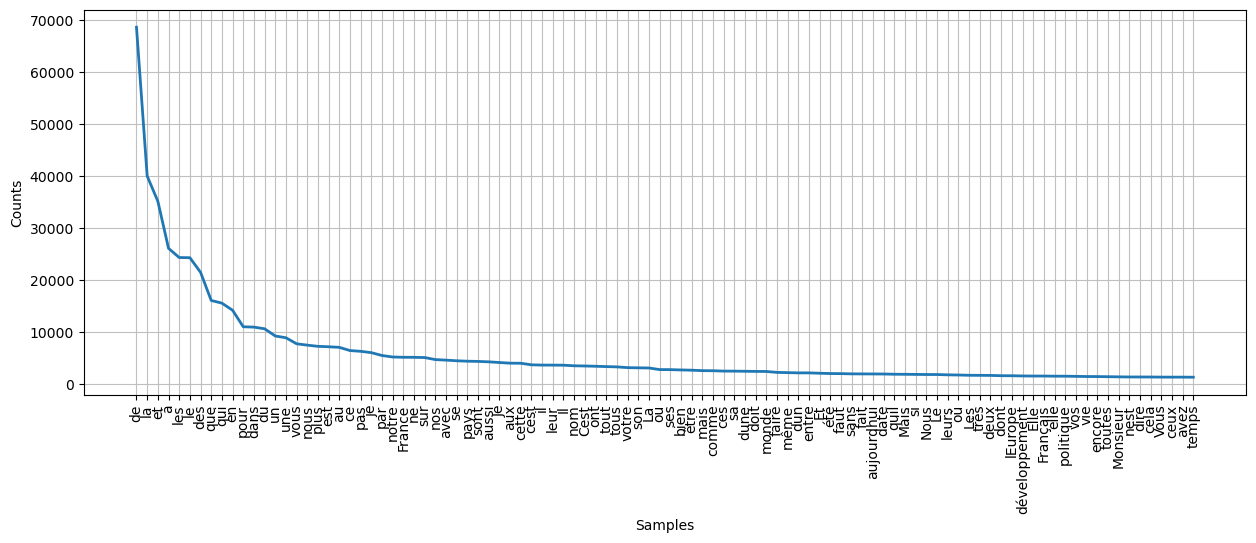

<Figure size 640x480 with 0 Axes>

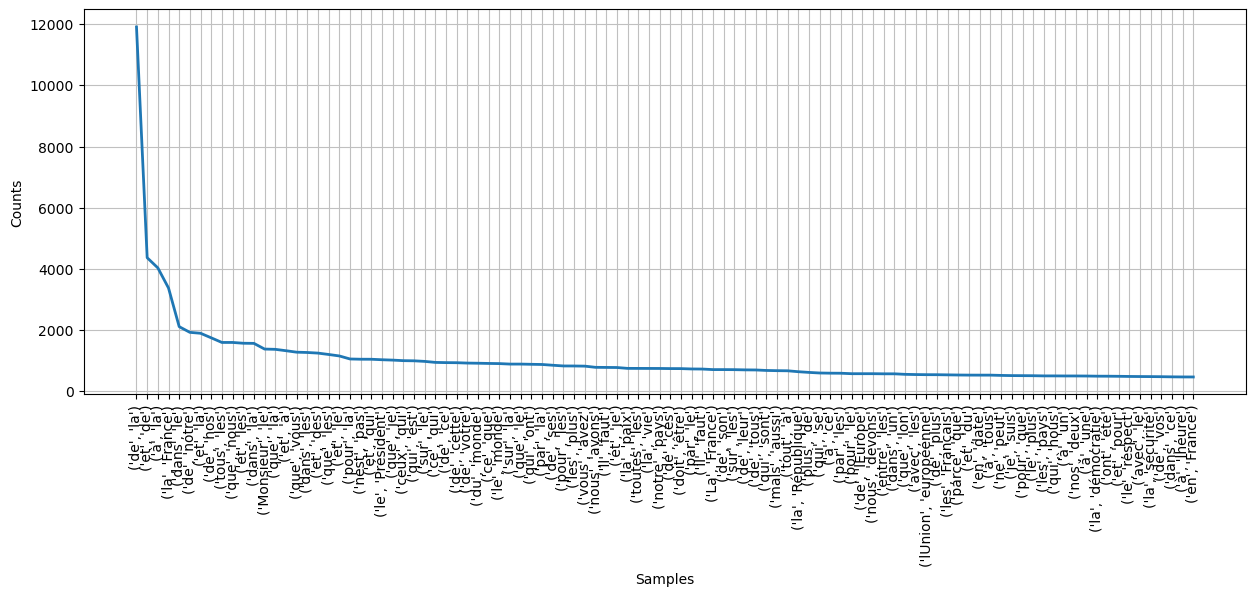

<Figure size 640x480 with 0 Axes>

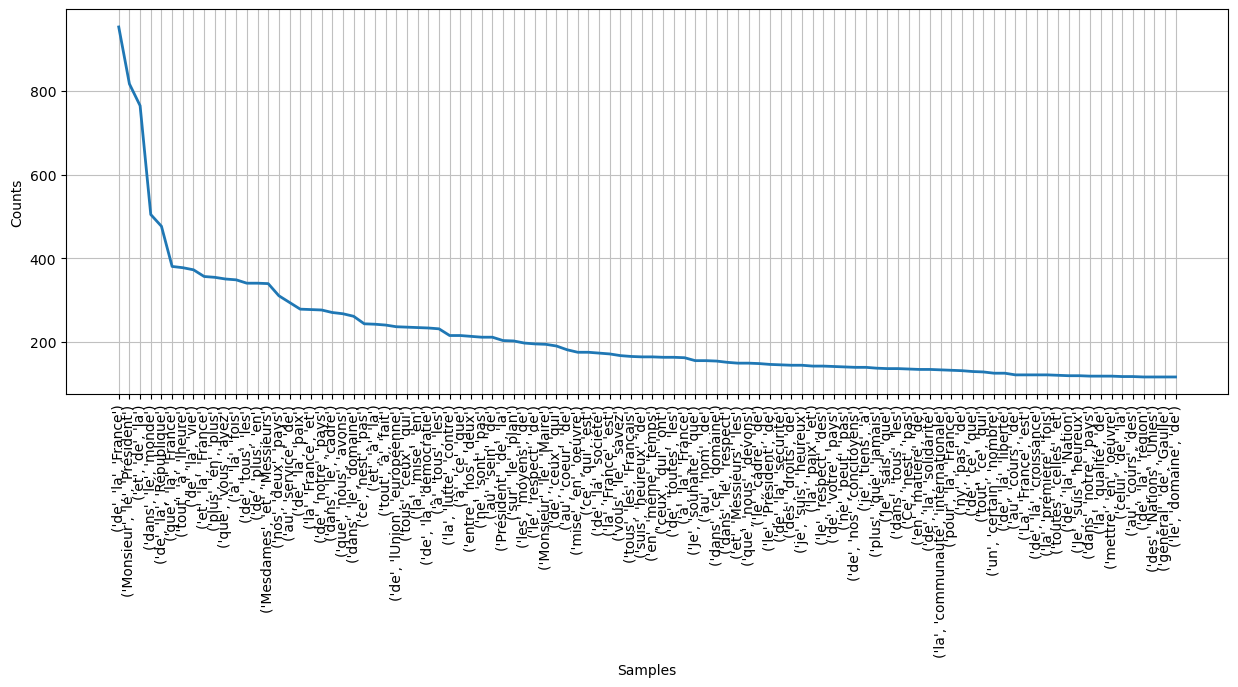

<Figure size 640x480 with 0 Axes>

In [11]:
plt.figure(figsize=(15, 5))
freq_dist.plot(100)
plt.savefig('figures/freq_dist.png')
plt.show()

plt.figure(figsize=(15, 5))
bigram_freq.plot(100)
plt.savefig('figures/bigram_freq.png')
plt.show()

plt.figure(figsize=(15, 5))
trigram_freq.plot(100)
plt.savefig('figures/trigram_freq.png')
plt.show()

# Identification préalable du meilleur modèle parmi différents modèles

A ce stade de l'analyse, on n'effectue pas encore de prétraitement sur les données. On va juste faire tourner différents modèles afin de trouver le modèle optimal à améliorer ensuite.

In [12]:
# import outils de preprocessing
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download("punkt")
nltk.download("stopwords")

from functools import partial
from unidecode import unidecode


def preprocess(text, remove_punctuation=True, use_stemming=True, remove_stopwords=True):
    # En anglais, à priori les accents et autres caractères spéciaux ne sont très utiles
    # dans ce contexte, je normalise donc le texte
    text = text.lower()
    text = unidecode(text)

    tokens = nltk.word_tokenize(text)

    if remove_punctuation:
        tokens = [token for token in tokens if token not in string.punctuation]

    if remove_stopwords:
        stop_words = set(stopwords.words("english"))
        tokens = [token for token in tokens if token not in stop_words]

    if use_stemming:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens]

    return " ".join(tokens)


[nltk_data] Downloading package punkt to /home/juldpnt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/juldpnt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Préparation du dataset pour l'apprentissage

On sépare le jeu de donneés en ensembles d'apprentissage et de test.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

train_texts, test_texts, train_labels, test_labels = train_test_split(alltxts, alllabs, test_size=0.2, random_state=42)

print("Taille de l'ensemble d'entraînement :", len(train_texts))
print("Taille de l'ensemble de test :", len(test_texts))

Taille de l'ensemble d'entraînement : 45930
Taille de l'ensemble de test : 11483


### Définition des différents modèles

On teste différents modèles : Naive Bayes, Logistic Regression, XG Boost et un SVM. Sans appliquer le prétraitement sur aucun des modèles, on obtient les résultats suivants :

In [14]:
from sklearn.naive_bayes import MultinomialNB


clf_NB = Pipeline(
    [
        ("vect", CountVectorizer(ngram_range=(1, 1))),
        ("TF-IDF", TfidfTransformer()),
        ("Sampler", RandomOverSampler(random_state=42)),
        ("clf", MultinomialNB()),
    ]
)

clf_NB.fit(train_texts, train_labels)
pred = clf_NB.predict(test_texts)

In [15]:
from sklearn.linear_model import LogisticRegression

clf_LR = Pipeline(
    [
        ("vect", CountVectorizer(ngram_range=(1, 1))),
        ("TF-IDF", TfidfTransformer()),
        ("Sampler", RandomOverSampler(random_state=42)),
        ("clf", LogisticRegression()),
    ]
)

clf_LR.fit(train_texts, train_labels)
pred = clf_LR.predict(test_texts)

/home/juldpnt/micromamba/envs/data-science-general/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
from xgboost import XGBClassifier

clf_XGB = Pipeline(
    [
        ("vect", CountVectorizer(ngram_range=(1, 1))),
        ("TF-IDF", TfidfTransformer()),
        ("Sampler", RandomOverSampler(random_state=42)),
        ("clf", XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max)),
    ]
)

clf_XGB.fit(train_texts, train_labels)
pred = clf_XGB.predict(test_texts)

In [27]:
from sklearn.svm import LinearSVC

clf_SVM = Pipeline(
    [
        ("vect", CountVectorizer(ngram_range=(1, 1))),
        ("TF-IDF", TfidfTransformer()),
        ("Sampler", RandomOverSampler(random_state=42)),
        ("clf", LinearSVC(C=1.0)),
    ]
)

clf_SVM.fit(train_texts, train_labels)

pred = clf_SVM.predict(test_texts)

/home/juldpnt/micromamba/envs/data-science-general/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


## Evaluation des modèles sans prétraitement

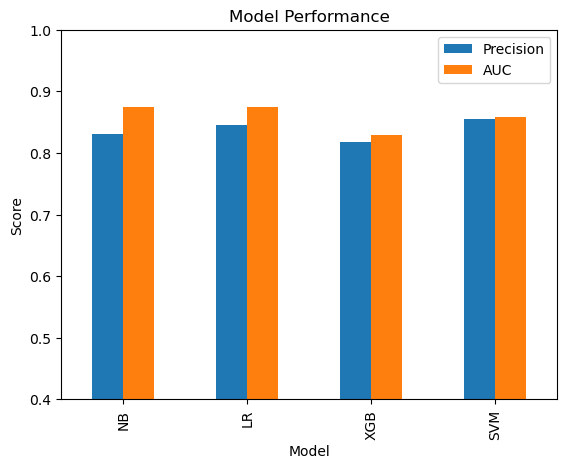

  Model  Precision       AUC
0    NB   0.831055  0.874611
1    LR   0.846120  0.874974
2   XGB   0.818776  0.828623
3   SVM   0.855351  0.857990 

Le modèle avec la meilleure précision est SVM
Le modèle avec le meilleur AUC est LR


In [18]:
from sklearn.metrics import accuracy_score, roc_curve, auc

# on va évaluer chaque modèle avec les métriques "précision" et "AUC"
modele = [clf_NB, clf_LR, clf_XGB, clf_SVM]

# Initialize a DataFrame to store the results
results = pd.DataFrame(columns=['Model', 'Precision', 'AUC'])

for i, model in enumerate(modele):
    model_name = ['NB', 'LR', 'XGB', 'SVM'][i]
    
    # Calculer la précision
    pred = model.predict(test_texts)
    precision = accuracy_score(test_labels, pred)

    # Cas particulier pour le modele SVM qui ne possède pas de méthode predict_proba
    if hasattr(model, 'predict_proba'):
        # Calculer l'auc
        pred_proba = model.predict_proba(test_texts)[:, 1]
    elif hasattr(model, 'decision_function'):  # utiliser decision_function pour le modele SVM qui n'a pas de méthode predict_proba
        pred_proba = model.decision_function(test_texts)
    else:
        print(f"Le modèle {model_name} n'a pas de méthode pour calculer la probabilité", "\n")
        continue

    fpr, tpr, _ = roc_curve(test_labels, pred_proba)
    roc_auc = auc(fpr, tpr)

    # Ajouter les résultats dans un DataFrame qu'on va ensuite afficher pour synthétiser les résultats
    results.loc[len(results)] = [model_name, precision, roc_auc]

# Afficher les résultats sous forme de graphique
results.plot(kind='bar', x='Model', y=['Precision', 'AUC'])
plt.title('Model Performance')
plt.ylabel('Score')
plt.ylim([0.4, 1])
plt.legend(['Precision', 'AUC'])
plt.show()

# Afficher le tableau de synthèse des résultats
print(results,"\n")

max_precision = results['Precision'].max()
max_auc = results['AUC'].max()

# Indiquer quels sont les modèles qui ont la meilleure précision et le meilleur AUC
best_precision_models = results[results['Precision'] == max_precision]['Model'].values
best_auc_models = results[results['AUC'] == max_auc]['Model'].values

print(f"Le modèle avec la meilleure précision est {', '.join(best_precision_models)}")
print(f"Le modèle avec le meilleur AUC est {', '.join(best_auc_models)}")


On observe à ce stade que le modèle avec les meilleures performances (selon les métriques évaluées) est le SVM. On va donc poursuivre en cherchant à améliorer ce modèle.

# Tentatives d'amélioration du meilleur modèle en utilisant différents prétraitements

On va mettre en place différents prétraitements pour voir si cela peut permettre d'augmenter les performances du modèle.

In [19]:
# import outils de preprocessing
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download("punkt")
nltk.download("stopwords")

from functools import partial
from unidecode import unidecode


def preprocess(text, remove_punctuation=True, use_stemming=True, remove_stopwords=True):
    # En anglais, à priori les accents et autres caractères spéciaux ne sont très utiles
    # dans ce contexte, on peut donc normaliser le texte en retirant ces caractères
    
    text = text.lower()
    text = unidecode(text)

    tokens = nltk.word_tokenize(text)

    if remove_punctuation:
        tokens = [token for token in tokens if token not in string.punctuation]

    if remove_stopwords:
        stop_words = set(stopwords.words("english"))
        tokens = [token for token in tokens if token not in stop_words]

    if use_stemming:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens]

    return " ".join(tokens)

[nltk_data] Downloading package punkt to /home/juldpnt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/juldpnt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


On va ensuite tester différentes combinaisons de ces trois pré-traitements pour entraîner le LinearSVC. On espère obtenir un modèle plus performant que sans les prétraitements.

In [28]:

from functools import partial

keep_punctuation = partial(preprocess, remove_punctuation=False)
keep_stopwords = partial(preprocess, remove_stopwords=False)
without_stemming = partial(preprocess, use_stemming=False)
quasi_non_preprocess = partial(
    preprocess, remove_punctuation=False, remove_stopwords=False, use_stemming=False
)

# Définit les modèles à tester
model = LinearSVC(C=1.0)
preprocessors = [
    ("SVM with all", preprocess),
    ("SVM (without extra preprocessing)", quasi_non_preprocess),
    ("SVM (keep punctuation)", keep_punctuation),
    ("SVM (keep stopwords)", keep_stopwords),
    ("SVM (without stemming)", without_stemming),
]


In [30]:
SVM_all = Pipeline(
    [
        ("vect", CountVectorizer(preprocessor=preprocess)),
        ("TF-IDF", TfidfTransformer()),
        ("Sampler", RandomOverSampler(random_state=42)),
        ("clf", LinearSVC(C=1.0)),
    ]
)
SVM_all.fit(train_texts, train_labels)

In [33]:
SVM_no_extra_preprocess = Pipeline(
    [
        ("vect", CountVectorizer(preprocessor=quasi_non_preprocess)),
        ("TF-IDF", TfidfTransformer()),
        ("Sampler", RandomOverSampler(random_state=42)),
        ("clf", LinearSVC(C=1.0)),
    ]
)
SVM_no_extra_preprocess.fit(train_texts, train_labels)

/home/juldpnt/micromamba/envs/data-science-general/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Pipeline(steps=[('vect',
                 CountVectorizer(preprocessor=functools.partial(<function preprocess at 0x7f75842aeee0>, remove_punctuation=False, remove_stopwords=False, use_stemming=False))),
                ('TF-IDF', TfidfTransformer()),
                ('Sampler', RandomOverSampler(random_state=42)),
                ('clf', LinearSVC())])

In [34]:
SVM_keep_punctuation = Pipeline(
    [
        ("vect", CountVectorizer(preprocessor=keep_punctuation)),
        ("TF-IDF", TfidfTransformer()),
        ("Sampler", RandomOverSampler(random_state=42)),
        ("clf", LinearSVC(C=1.0)),
    ]
)
SVM_keep_punctuation.fit(train_texts, train_labels)

/home/juldpnt/micromamba/envs/data-science-general/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Pipeline(steps=[('vect',
                 CountVectorizer(preprocessor=functools.partial(<function preprocess at 0x7f75842aeee0>, remove_punctuation=False))),
                ('TF-IDF', TfidfTransformer()),
                ('Sampler', RandomOverSampler(random_state=42)),
                ('clf', LinearSVC())])

In [37]:
SVM_keep_stopwords = Pipeline(
    [
        ("vect", CountVectorizer(preprocessor=keep_stopwords)),
        ("TF-IDF", TfidfTransformer()),
        ("Sampler", RandomOverSampler(random_state=42)),
        ("clf", LinearSVC(C=1.0)),
    ]
)

SVM_keep_stopwords.fit(train_texts, train_labels)

/home/juldpnt/micromamba/envs/data-science-general/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Pipeline(steps=[('vect',
                 CountVectorizer(preprocessor=functools.partial(<function preprocess at 0x7f75842aeee0>, remove_stopwords=False))),
                ('TF-IDF', TfidfTransformer()),
                ('Sampler', RandomOverSampler(random_state=42)),
                ('clf', LinearSVC())])

In [38]:
SVM_without_stemming = Pipeline(
    [
        ("vect", CountVectorizer(preprocessor=without_stemming)),
        ("TF-IDF", TfidfTransformer()),
        ("Sampler", RandomOverSampler(random_state=42)),
        ("clf", LinearSVC(C=1.0)),
    ]
)
SVM_without_stemming.fit(train_texts, train_labels)

/home/juldpnt/micromamba/envs/data-science-general/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Pipeline(steps=[('vect',
                 CountVectorizer(preprocessor=functools.partial(<function preprocess at 0x7f75842aeee0>, use_stemming=False))),
                ('TF-IDF', TfidfTransformer()),
                ('Sampler', RandomOverSampler(random_state=42)),
                ('clf', LinearSVC())])

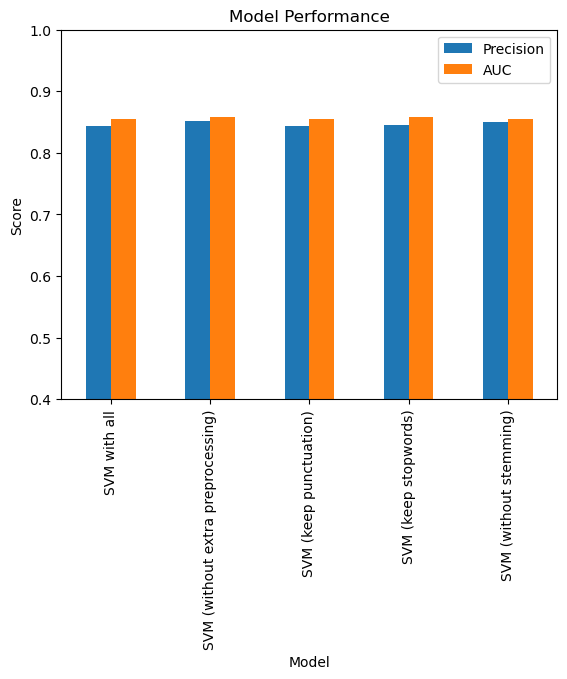

                               Model  Precision       AUC
0                       SVM with all   0.842898  0.855225
1  SVM (without extra preprocessing)   0.852303  0.858221
2             SVM (keep punctuation)   0.842811  0.855225
3               SVM (keep stopwords)   0.844727  0.857978
4             SVM (without stemming)   0.849691  0.855370 

Le modèle avec la meilleure précision est SVM (without extra preprocessing)
Le modèle avec le meilleur AUC est SVM (without extra preprocessing)


In [39]:
from sklearn.metrics import accuracy_score, roc_curve, auc

# on va évaluer chaque modèle avec les métriques "précision" et "AUC"
modele = [SVM_all, SVM_no_extra_preprocess,
          SVM_keep_punctuation, SVM_keep_stopwords, 
          SVM_without_stemming]

# Initialize a DataFrame to store the results
results = pd.DataFrame(columns=['Model', 'Precision', 'AUC'])

for i, model in enumerate(modele):
    model_name = preprocessors[i][0]    
    
    
    # Calculer la précision
    pred = model.predict(test_texts)
    precision = accuracy_score(test_labels, pred)

    # Cas particulier pour le modele SVM qui ne possède pas de méthode predict_proba
    if hasattr(model, 'predict_proba'):
        # Calculer l'auc
        pred_proba = model.predict_proba(test_texts)[:, 1]
    elif hasattr(model, 'decision_function'):  # utiliser decision_function pour le modele SVM qui n'a pas de méthode predict_proba
        pred_proba = model.decision_function(test_texts)
    else:
        print(f"Le modèle {model_name} n'a pas de méthode pour calculer la probabilité", "\n")
        continue

    fpr, tpr, _ = roc_curve(test_labels, pred_proba)
    roc_auc = auc(fpr, tpr)

    # Ajouter les résultats dans un DataFrame qu'on va ensuite afficher pour synthétiser les résultats
    results.loc[len(results)] = [model_name, precision, roc_auc]

# Afficher les résultats sous forme de graphique
results.plot(kind='bar', x='Model', y=['Precision', 'AUC'])
plt.title('Model Performance')
plt.ylabel('Score')
plt.ylim([0.4, 1])
plt.legend(['Precision', 'AUC'])
plt.show()

# Afficher le tableau de synthèse des résultats
print(results,"\n")

max_precision = results['Precision'].max()
max_auc = results['AUC'].max()

# Indiquer quels sont les modèles qui ont la meilleure précision et le meilleur AUC
best_precision_models = results[results['Precision'] == max_precision]['Model'].values
best_auc_models = results[results['AUC'] == max_auc]['Model'].values

print(f"Le modèle avec la meilleure précision est {', '.join(best_precision_models)}")
print(f"Le modèle avec le meilleur AUC est {', '.join(best_auc_models)}")

Il ne semble pas y avoir de différence significative entre les modèles avec et sans préprocessing. Cependant je n'ai pas fait de cross validation car le temps de calcul était très élevé. 

Ces résultats sont nécessairement très dépendants du type mono/bi/trigramme utilisé pour les tokens. Il faudrait en revanche tester l'ensemble des combinaisons de prétraitements pour pouvoir conclure quant à leur influence.

Des tests ont été réalisés avec différentes valeurs de ngram_range, et les différences de résultats étaient en réalité très variables d'un run à l'autre. Il faudrait donc également faire une cross validation pour pouvoir conclure quant à l'influence de ce paramètre, mais avec une machine plus puissante.

# Optimisation des hyperparamètres du modèle le plus performant

Une fois le meilleur modèle identifié, on va chercher à optimiser ses hyperparamètres. On va utiliser un grid search pour cela.

On obtient que le paramètre C optimal est égal à 1.

In [53]:
test_set, _ = load_pres("data/AFDpresidentutf8/corpus.tache1.test.utf8")


In [54]:
predictions = SVM_all.predict(test_set)

In [62]:
trad = {0: "C", 1: "M"}

with open('results/prediction.txt', 'w') as f:
    for result in predictions:
        f.write(f"{trad[result]}\n")